In [ ]:
!pip install -U transformers peft bitsandbytes datasets scikit-learn feedparser


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import torch
import pandas as pd
import torch.nn as nn
import torch
import numpy as np
import feedparser
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

os.environ["WANDB_DISABLED"] = "true"


In [ ]:
df_liar = pd.read_csv("/content/drive/MyDrive/misinfo_project/liar/liar_train.csv")
df_fakenewsnet = pd.read_csv("/content/drive/MyDrive/misinfo_project/fakenewsnet/fakenewsnet_train.csv")


In [ ]:

df_train = pd.concat([df_liar, df_fakenewsnet], ignore_index=True)
df_train.dropna(subset=["text", "label"], inplace=True)
df_train["label"] = df_train["label"].astype(int)

df_real = df_train[df_train["label"] == 1]
df_train = pd.concat([df_train, df_real, df_real], ignore_index=True)


In [ ]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

model_name = "microsoft/phi-2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    num_labels=2,
    trust_remote_code=True,
    device_map="auto"
)

base_model = prepare_model_for_kbit_training(base_model)

peft_config = LoraConfig(
    task_type="SEQ_CLS",
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj", "k_proj", "v_proj", "dense"]
)

model = get_peft_model(base_model, peft_config)
model.gradient_checkpointing_enable()
model.config.use_cache = False
model.print_trainable_parameters()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of PhiForSequenceClassification were not initialized from the model checkpoint at microsoft/phi-2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 5,248,000 || all params: 2,653,813,760 || trainable%: 0.1978


In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

train_dataset = Dataset.from_pandas(df_train).map(tokenize_function, batched=True)
train_dataset = train_dataset.remove_columns(["text"])
train_dataset.set_format("torch")


Map:   0%|          | 0/18191 [00:00<?, ? examples/s]

In [ ]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=df_train["label"]
)
class_weights = torch.tensor(class_weights, dtype=torch.float)


In [ ]:
class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8):
        super(AsymmetricLoss, self).__init__()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.eps = eps

    def forward(self, logits, targets):
        num_classes = logits.shape[1]
        targets = nn.functional.one_hot(targets, num_classes).float()

        preds = torch.sigmoid(logits)
        preds = torch.clamp(preds, min=self.eps, max=1 - self.eps)

        pos_preds = preds
        neg_preds = 1 - preds

        if self.clip is not None and self.clip > 0:
            neg_preds = (neg_preds + self.clip).clamp(max=1)

        pos_loss = targets * torch.log(pos_preds)
        neg_loss = (1 - targets) * torch.log(neg_preds)

        loss = pos_loss + neg_loss

        asymmetric_weight = torch.pow(1 - preds * targets - (1 - preds) * (1 - targets),
                                       self.gamma_pos * targets + self.gamma_neg * (1 - targets))
        loss *= asymmetric_weight

        return -loss.mean()


In [ ]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = AsymmetricLoss(gamma_neg=4, gamma_pos=1, clip=0.05)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [ ]:
training_args = TrainingArguments(
    output_dir="./phi2_misinfo",
    num_train_epochs=3,
    per_device_train_batch_size=1,
    learning_rate=3e-6,
    weight_decay=0.05,
    logging_steps=100,
    save_steps=500,
    save_total_limit=2,
    fp16=True,
    report_to="none"
)


In [14]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer
)

trainer.train()


<ipython-input-14-2f298d74dae1>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
100,0.145000
200,0.142100
300,0.238900


Step,Training Loss
100,0.145000
200,0.142100
300,0.238900
400,0.331500
500,0.326800
600,0.291700
700,0.347200
800,0.301600
900,0.293100
1000,0.394300


TrainOutput(global_step=54573, training_loss=0.3775781258164415, metrics={'train_runtime': 22079.1629, 'train_samples_per_second': 2.472, 'train_steps_per_second': 2.472, 'total_flos': 4.2293325640237056e+17, 'train_loss': 0.3775781258164415, 'epoch': 3.0})

In [15]:
model.save_pretrained("/content/drive/MyDrive/misinfo_project/models/phi2_it2")
tokenizer.save_pretrained("/content/drive/MyDrive/misinfo_project/models/phi2_it2")

('/content/drive/MyDrive/misinfo_project/models/phi2_it2/tokenizer_config.json',
 '/content/drive/MyDrive/misinfo_project/models/phi2_it2/special_tokens_map.json',
 '/content/drive/MyDrive/misinfo_project/models/phi2_it2/vocab.json',
 '/content/drive/MyDrive/misinfo_project/models/phi2_it2/merges.txt',
 '/content/drive/MyDrive/misinfo_project/models/phi2_it2/added_tokens.json',
 '/content/drive/MyDrive/misinfo_project/models/phi2_it2/tokenizer.json')

Map:   0%|          | 0/1267 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-16-5df593a0deee>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(model=model, args=eval_args, tokenizer=tokenizer)
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


<Figure size 600x500 with 0 Axes>

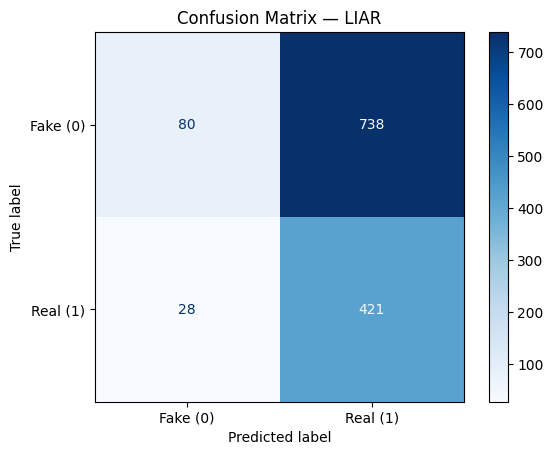


Evaluation Metrics for LIAR:
Accuracy:  0.3954
Precision: 0.3632
Recall:    0.9376
F1 Score:  0.5236


Map:   0%|          | 0/85 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-16-5df593a0deee>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(model=model, args=eval_args, tokenizer=tokenizer)
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


<Figure size 600x500 with 0 Axes>

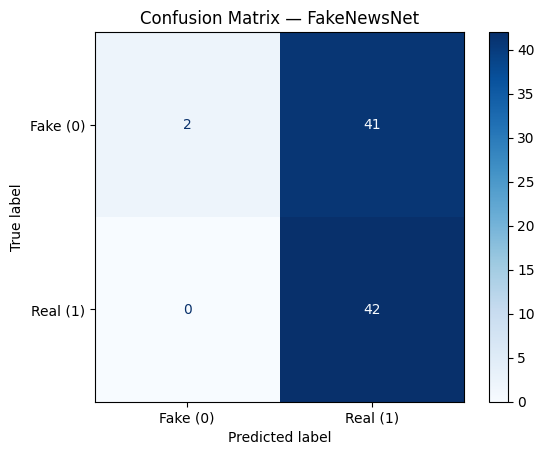


Evaluation Metrics for FakeNewsNet:
Accuracy:  0.5176
Precision: 0.5060
Recall:    1.0000
F1 Score:  0.6720


In [16]:
def evaluate_model(test_path, dataset_name):
    df_test = pd.read_csv(test_path)
    df_test = df_test.dropna(subset=["text", "label"])
    df_test["label"] = df_test["label"].astype(int)

    test_dataset = Dataset.from_pandas(df_test).map(tokenize_function, batched=True)
    test_dataset = test_dataset.remove_columns(["text"])
    test_dataset.set_format("torch")

    eval_args = TrainingArguments(output_dir="./eval_temp", per_device_eval_batch_size=4, fp16=True)
    eval_trainer = Trainer(model=model, args=eval_args, tokenizer=tokenizer)
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id
    predictions = eval_trainer.predict(test_dataset)

    preds = np.argmax(predictions.predictions, axis=1)
    true_labels = predictions.label_ids

    cm = confusion_matrix(true_labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake (0)", "Real (1)"])

    plt.figure(figsize=(6, 5))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix — {dataset_name}")
    plt.grid(False)
    plt.show()

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average="binary", zero_division=0)
    accuracy = accuracy_score(true_labels, preds)

    print(f"\nEvaluation Metrics for {dataset_name}:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

evaluate_model("/content/drive/MyDrive/misinfo_project/liar/liar_test.csv", "LIAR")
evaluate_model("/content/drive/MyDrive/misinfo_project/fakenewsnet/fakenewsnet_test.csv", "FakeNewsNet")
